# Reuters Clustering Example

## Load data

In [1]:
# Import libraries

# Main
import sys
sys.path.insert(0,'../')
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

# NLP
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords

# Transformers
from transformers import AutoTokenizer, TFAutoModel

# Sklearn
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

# Display
from IPython.display import clear_output

clear_output()

### Covid Data

Twitter and reddit datasets.

In [2]:
from utils import Utils
utils = Utils('/media/juan/Juan/NLP/', num_workers=10)

In [3]:
# Define language
lang = 'es'

print('Starting...')
twitter_data, twitter_dates = utils.data_loader(lang, 'tweets', total_data=125000, max_size = 300, return_dates = True)
reddit_data, reddit_dates = utils.data_loader(lang, 'reddit', total_data=7000, max_size = 300, return_dates = True)

print(f'Loaded {len(twitter_data)} Tweets {len(reddit_data)} Reddit docs')

Starting...
Starting threads to load 125000 documents from tweets in es
Loaded 125000 files in 21.55 seconds.
Removed 0 files becasuse they were too large
Starting threads to load 7000 documents from reddit in es
Loaded 6479 files in 6.84 seconds.
Removed 521 files becasuse they were too large
Loaded 125000 Tweets 6479 Reddit docs


### Reuters Dataset

Reuters news dataset (baseline)

In [ ]:
# Download data set
try:
    from nltk.corpus import reuters
except:
    nltk.download('reuters')
    !unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora
    from nltk.corpus import reuters

In [31]:
# Extract dataset
raw_data = []
raw_labels = []
for file in reuters.fileids():
    raw_data.append(reuters.raw(file))
    raw_labels.append(reuters.categories(file))

In [32]:
# let's consider only 5 categories
our_labels = ['crude', 'coffee', 'grain', 'gold']

# def arrays
data = []
labels = []

# Extract only 5 categories
for i in range(len(raw_labels)):
    if any(item in raw_labels[i] for item in our_labels) and len(raw_data[i].split())<300:
        data.append(raw_data[i])
        labels.append(raw_labels[i])

In [33]:
# Code labels to just one number
new_labels = []
for label in labels:
    for i, our_lb in enumerate(our_labels):
        if our_lb in label :
            new_labels.append(i)
            break

In [34]:
print(f'Total documents: {len(new_labels)}')

Total documents: 1164


## Preprocessing

In [5]:
# Stop Words
stop_words = stopwords.words('spanish')

# Stemmers
stem = SnowballStemmer('spanish')
#p_stem = PorterStemmer()

# Tokenizers
#tk = nltk.tokenize.TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
tk = nltk.RegexpTokenizer(r'\w+')

# Lemmatizer
lemma = nltk.stem.WordNetLemmatizer()

# Preprocess data
corpus = []
for d in reddit_data+twitter_data:
    corpus.append(utils.preprocessing(d, stop_words = stop_words,
                                         stemmer = None,
                                         tokenizer = tk,
                                         lemmatizer = lemma))
print(len(corpus))

131479


## BERT Embedding

In [6]:
# Bert-Large instance (COVID) IF WE HAD TIME
#tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
#model = TFAutoModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2", output_hidden_states=False)

# Bert instance EN (COVID)
#tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-covid19-base-uncased")
#model = TFAutoModel.from_pretrained("vinai/bertweet-covid19-base-uncased", output_hidden_states=False)

# Bert instance FR
#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-french-europeana-cased")
#model = TFAutoModel.from_pretrained("dbmdz/bert-base-french-europeana-cased", output_hidden_states=True)

# Bert instance ES (BETICO)
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = TFAutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", output_hidden_states=False)

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Test Model for first sentence
inputs = tokenizer(corpus[0], padding='max_length', return_tensors="tf", is_split_into_words=True)
outputs = model(**inputs)

# Just pooler output as embeddings
embedding = outputs['pooler_output'][0].numpy()

In [8]:
# Array to save embeddings
reu_embeddings = []

failed_doc_ids = []

for i, doc in enumerate(tqdm(corpus)):
    try:
        # Run Bert for each document
        inputs = tokenizer(doc, return_tensors="tf", is_split_into_words=True)
        outputs = model(**inputs)

        # CLS Token Output
        embedding = outputs['pooler_output'][0].numpy()
        
        # Append representation
        reu_embeddings.append(embedding)
        
    except:
        failed_doc_ids.append(i)

# Remove doc
for doc_id in failed_doc_ids:
    corpus.pop(doc_id)
    reddit_dates.pop(doc_id)

100%|██████████| 131479/131479 [4:03:02<00:00,  9.02it/s]  


## Autoencoder

In [9]:
# Declare autoencoder
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   

        self.encoder = tf.keras.models.Sequential()
        self.encoder.add(tf.keras.Input(shape=(768,)))
        #self.encoder.add(layers.Dense(300, activation='relu'))
        self.encoder.add(layers.Dense(latent_dim, activation='linear'))

        self.decoder = tf.keras.models.Sequential()
        #self.decoder.add(layers.Dense(300, activation='relu'))
        self.decoder.add(tf.keras.layers.Dense(768, activation='linear'))

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
# Compile autoencoder
latent_dim = 32
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Train
autoencoder.fit(np.asarray(reu_embeddings), np.asarray(reu_embeddings), epochs=15, shuffle=True)

Epoch 1/15
4109/4109 [==============================] - 3s 784us/step - loss: 0.0177
Epoch 2/15
4109/4109 [==============================] - 3s 785us/step - loss: 0.0161
Epoch 3/15
4109/4109 [==============================] - 3s 808us/step - loss: 0.0160
Epoch 4/15
4109/4109 [==============================] - 3s 806us/step - loss: 0.0159
Epoch 5/15
4109/4109 [==============================] - 3s 806us/step - loss: 0.0159
Epoch 6/15
4109/4109 [==============================] - 3s 815us/step - loss: 0.0159
Epoch 7/15
4109/4109 [==============================] - 3s 777us/step - loss: 0.0159
Epoch 8/15
4109/4109 [==============================] - 3s 787us/step - loss: 0.0159
Epoch 9/15
4109/4109 [==============================] - 3s 773us/step - loss: 0.0159
Epoch 10/15
4109/4109 [==============================] - 3s 785us/step - loss: 0.0159
Epoch 11/15
4109/4109 [==============================] - 3s 807us/step - loss: 0.0159
Epoch 12/15
4109/4109 [==============================] - 3s 799

In [11]:
encoded_reu = autoencoder.encoder(np.asarray(reu_embeddings)).numpy()

## Clustering

In [12]:
# Principal component analysis for dim reduction (optional)
pca = PCA(n_components=2)
X = pca.fit_transform(encoded_reu)

In [89]:
# K MEANS CLUSTERING
k_means = KMeans(2, max_iter = 1000)
clusters_kmeans = k_means.fit_predict(encoded_reu)

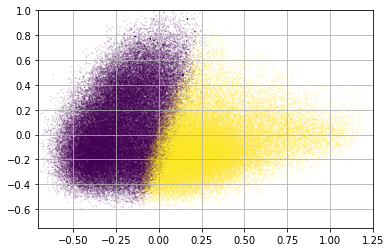

In [100]:
path_to_save = '../../results/TopicDetection/es/'
plt.scatter(X[:,0],X[:,1], s=0.01, c=clusters_kmeans)
plt.ylim([-0.75, 1])
plt.xlim([-0.7, 1.25])
plt.grid(True)
plt.savefig(os.path.join(path_to_save, 'PCA_2.png'))
plt.show()

## Results: KeyWords

Just for K-Means :/

In [43]:
from scipy.spatial import distance

def get_relevant_docs_from_clusters(clustering, embeddings, n_relevant_docs=5):
  
    # Init relevant docs list
    relevant_docs_id = []

    # Get cluster and centers
    centers = clustering.cluster_centers_
    clusters = clustering.labels_

    emb_distances = []

    # Loop around doc embeddings
    for i, emb in enumerate(embeddings):
        # Compute distance between embedding and cluster center
        emb_distances.append(distance.pdist([emb, centers[clusters[i]]]).item(0))

    # Sort distances
    sorted_index = np.argsort(emb_distances)
    emb_distances = np.array(emb_distances)[sorted_index[::-1]]
    clusters = np.array(clusters)[sorted_index[::-1]]

    # Select n relevant docs for each cluster
    for i in range(clustering.n_clusters):
        relevant_docs_cluster = []

        for j, dist in enumerate(emb_distances):
            #print(dist)
            if i == clusters[j]:
                relevant_docs_cluster.append(sorted_index[j])

            if len(relevant_docs_cluster) > n_relevant_docs:
                break

        relevant_docs_id.append(relevant_docs_cluster)

    return relevant_docs_id

In [44]:
def print_relevant_keys_from_docs(docs_id, min_words=4, ignore_words=['covid', 'covid19', 'coronavirus']):
    
    key_words_list = []
    
    # Loop around docs
    for i, docs in enumerate(docs_id):

        # Init tokens array
        tokens = []
        for doc_id in docs:
            # split() returns list of all the words in the string
            tokens = tokens + corpus[doc_id]

        # Pass the list to instance of Counter class.
        key_words = Counter(tokens)
        keys = list(key_words.keys())
        
        # Remove non relevant key_words
        for k in keys:
            if (key_words[k] < min_words) or (k in ignore_words):
                del key_words[k]
        
        key_words_list.append(key_words)
        print(f'Cluster {i}: {key_words}')
        print('')
        
    return key_words_list
    

In [93]:
from collections import Counter

docs_id = get_relevant_docs_from_clusters(k_means, encoded_reu, n_relevant_docs=200)

# Lista de palabras a ignorar
ignore_words_fr = ['covid', 'covid19', 'coronavirus', 'a', 'ça', 'cest', 'plus', 'tout', 'bien', 'via']
ignore_words_es = ['covid', 'covid19', 'coronavirus', 'gente', 'si', 'personas', 'aún', 'mas', 'bien', 'via', 'q', 'd', 'casos']

key_words_list = print_relevant_keys_from_docs(docs_id, min_words=6, ignore_words=ignore_words_es)


Cluster 0: Counter({'pandemia': 23, 'hoy': 14, 'salud': 12, 'semana': 11, 'hace': 10, 'ahora': 10, 'contagios': 9, 'mayo': 9, 'día': 9, 'mundo': 8, 'dos': 7, '2021': 7, 'solo': 7, 'medidas': 7, 'así': 7, 'méxico': 7, 'gobierno': 7, 'país': 6, 'tener': 6, '20': 6, 'segunda': 6, 'va': 6, 'fallecidos': 6, 'fin': 6, 'ver': 6, 'mundial': 6})

Cluster 1: Counter({'vacunación': 18, 'pandemia': 15, 'contagios': 11, 'así': 11, 'año': 10, '2021': 10, 'hoy': 10, 'vacunas': 10, 'nuevos': 10, 'salud': 9, '1': 8, 'x': 8, 'pacientes': 8, 'mundo': 7, 'país': 7, 'ver': 7, 'gobierno': 6, 'mayo': 6, 'muertos': 6, 'causa': 6, 'dos': 6, 'vez': 6, 'ir': 6, 'va': 6, 'través': 6, 'familia': 6, 'mil': 6, 'mal': 6, 'colombia': 6})



### WordCount Plots

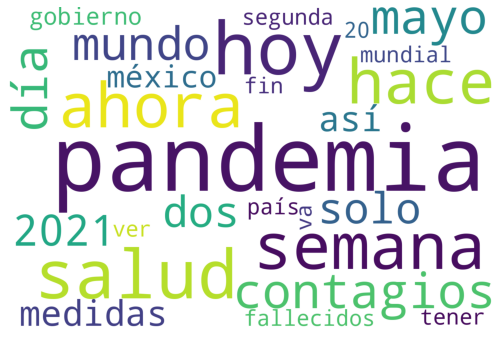

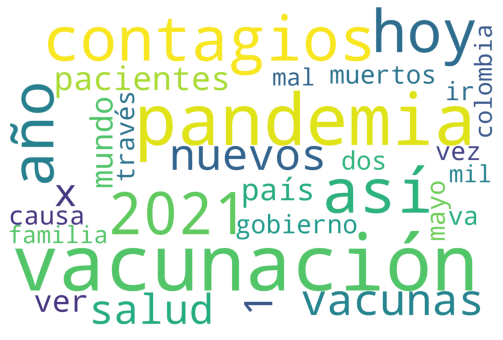

In [101]:
from wordcloud import WordCloud

for i, key_words in enumerate(key_words_list):
    
    wordcloud = WordCloud(background_color='white',
                          width=1500,
                          height=1000
                          ).generate_from_frequencies(key_words)

    plt.figure(figsize=(9,6))
    plt.imshow(wordcloud)
    plt.axis('off')
#     plt.title(f'Cluster N° {i}', fontsize = 25)
    plt.savefig(os.path.join(path_to_save, 'cluster' + str(i) + '.png'))
    plt.show()

### Time Analysis

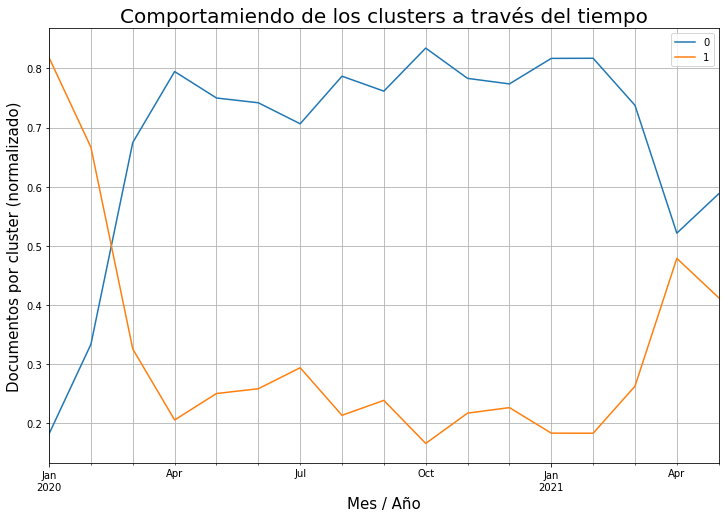

In [102]:
# Init clusters dic
clusters_data = np.zeros((len(corpus), k_means.n_clusters))

# Count by clusters
for i, lb in enumerate(k_means.labels_):
    clusters_data[i,lb] = 1 

# Group by month_year
clusters_df = pd.DataFrame(data = clusters_data)
clusters_df['date'] = reddit_dates + twitter_dates
clusters_df['month_year'] = clusters_df['date'].dt.to_period('M')

# Plot
df = clusters_df.groupby('month_year').sum().copy()
df = df.div(df.sum(axis=1),axis=0)
df.plot(figsize=(12,8))
plt.grid(which='both')
plt.title('Comportamiendo de los clusters a través del tiempo', fontsize=20)
plt.ylabel('Documentos por cluster (normalizado)', fontsize=15)
plt.xlabel('Mes / Año', fontsize=15)
plt.savefig(os.path.join(path_to_save, 'cluster_over_time.png'))
plt.show()
